In [125]:
packageVersion("ggplot2")
find.package("ggplot2")

[1] '3.5.1'

[1] "C:/Users/LiLi/AppData/Local/R/win-library/4.2/ggplot2"

In [126]:


install.packages("nnet")


Installation du package dans 'C:/Users/LiLi/AppData/Local/R/win-library/4.2'
(car 'lib' n'est pas spécifié)




  Une version binaire est disponible mais la version du source est plus
  récente:
     binary source needs_compilation
nnet 7.3-19 7.3-20              TRUE

  Binaries will be installed
le package 'nnet' a été décompressé et les sommes MD5 ont été vérifiées avec succés


Warning message:
"impossible de supprimer l'installation précédente du package 'nnet'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problème lors de la copie de C:\Users\LiLi\AppData\Local\R\win-library\4.2\00LOCK\nnet\libs\x64\nnet.dll vers C:\Users\LiLi\AppData\Local\R\win-library\4.2\nnet\libs\x64\nnet.dll: Permission denied"
Warning message:
"'nnet' restauré"



Les packages binaires téléchargés sont dans
	C:\Users\LiLi\AppData\Local\Temp\RtmpY5S2fV\downloaded_packages


# R Experience Level:  Regression logistique, LDA, KNN, SVM

In [127]:
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(recipes)
library(caret)
library(e1071)


In [128]:
#library(nnet)
library(mlr3)
library(mlr3learners)
library(RColorBrewer)
library(e1071)
library(rpart)
#library(rpart.plot)

In [129]:
# fix random seed for reproducibility
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)


## DATA LOADING & PROCESSING ##
# Load data
path <- "../../" # modifier le nombre de ../ si nécessaire
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

gym <- gym %>% select(-c(BMI))

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
scaler <- scale(gym_train[,-c(2,10,13,14)])

# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")

gym_train_scaled[,-c(2,10,13,14)] <- scale(gym_train[,-c(2,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,10,13,14)] <- scale(gym_test[,-c(2,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")

Data loaded and preprocessed

In [130]:

## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

#Fonction qui calcule et affiche le pourcentage d'erreur 
#à partirde la matrice de confusion

pourcentage_erreur <- function(conf_matrix) {
  total_samples <- sum(conf_matrix)
  errors <- total_samples - sum(diag(conf_matrix))
  error_percentage <- (errors / total_samples) * 100
  print(paste("Pourcentage d'erreur :", round(error_percentage, 2), "%"))
}

# Initialiser tableau des résultats
results <- data.frame(
  Methode = character(),
  Score = numeric(),
  Temps = numeric(),
  stringsAsFactors = FALSE
)

## Regression logistique (optimisation Lasso)

La régréssion logistque réalisée ici est multinomiale pour être adaptée à notre problème de clasification et prend en comte les interactions doubles. 
La fonction R glmnet calcule tous les modèles lasso (pénalisation L1, alpha=1 en argument) pour une séquence de 100 lambda puis évalue leurs performances par validation croisée. 

 Les données utilisés sont les donnnés "scalers" (moyenne à 0 ecart-type à 1) pour ne pas donner plus d'importance à certaines variables (glmnet fait des pénalisation avec les normes L1 (alpha=1)).

[1] "Temps d'exécution :  1.85748100280762"
[1] "Best Lambda : 0.000566060562817942"
[1] "LSE Lambda : 0.0069786591919684"


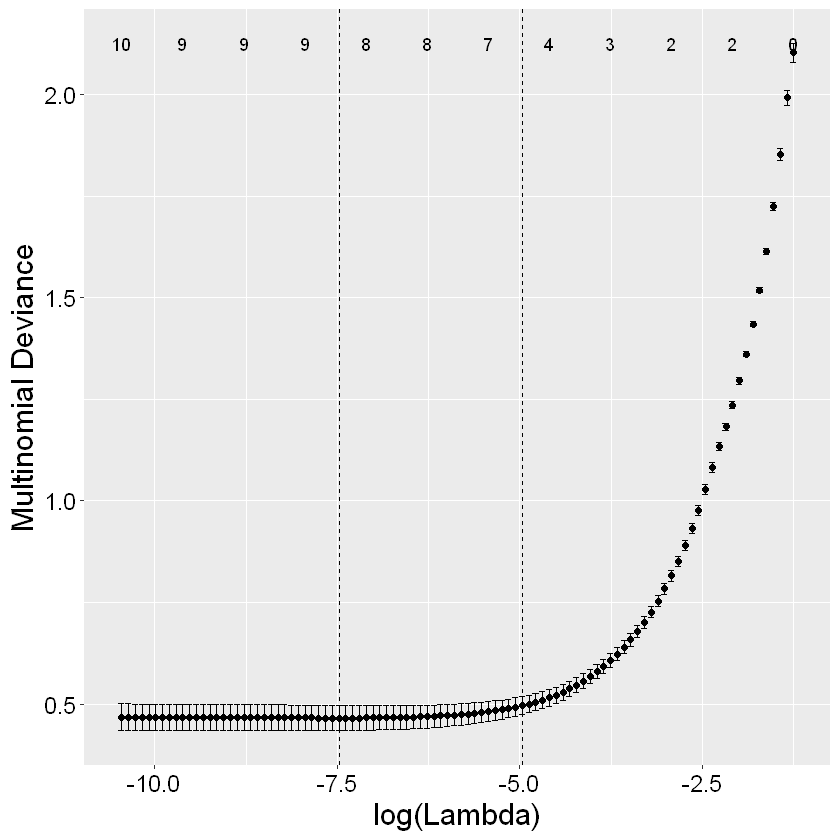

In [131]:
t0 <- Sys.time()

# Convertir les données en matrice pour glmnet
# si ~ .^2 => erreur = 15% environ
x <- model.matrix(Experience_Level ~ ., data = gym_train_scaled)[, -1] # Prédicteurs 
y <- model.matrix(~ Experience_Level + 0, data = gym_train_scaled)      # Réponse

# Ajustement du modèle avec validation croisée
cv_fit <- cv.glmnet(x, y, family = "multinomial", alpha = 1)
autoplot(cv_fit)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# Afficher le meilleur lambda
best_lambda <- cv_fit$lambda.min
print(paste("Best Lambda :", best_lambda))

#Affiche le plus grand lambda envisageable
lse_lambda <- cv_fit$lambda.1se
print(paste("LSE Lambda :", lse_lambda))

- lambda petit= moins de pénalisation, modèle complexe avec beaucoup de variables non nulles 
- lambda grand= plus depénalisation, modèle simple avec bcp de coefs nulles
- courbe = performance sur validation croisée sauf forme erreur de prédiction

Le plus grand lambda qui minimise la deviance est lambda min = 0.000295; et le plus grand lambda dont la déviance est à moins de un écart-type du minimum est LSE lambda= 0.0052791. On garde ce dernier qui fait un compromis entre la simplicité et la robustesse du modèle. 

Le choix du lamabda nous permet de réduire le nombre de coeffcients selectionnés.


In [132]:
# Choix du lambda
chosen_lambda <- lse_lambda

# Ajuster le modèle final avec le meilleur lambda
final_model <- glmnet(x, y, family = "multinomial", alpha = 1, lambda = chosen_lambda)

# Afficher les coefficients du modèle final
print(coef(final_model))

$Experience_Level1
18 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                                2.76270639
Age                             0.04454661
GenderMale                      .         
LWeight                         .         
Height..m.                      0.01526018
Max_BPM                         .         
Avg_BPM                         .         
Resting_BPM                     .         
Session_Duration..hours.       -1.15464048
Calories_Burned                -0.17927720
Workout_TypeHIIT                .         
Workout_TypeStrength            .         
Workout_TypeYoga                .         
SFat_Percentage                 .         
Water_Intake..liters.           .         
Workout_Frequency..days.week.3  .         
Workout_Frequency..days.week.4 -5.94077471
Workout_Frequency..days.week.5  .         

$Experience_Level2
18 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                 

In [133]:
# Extraire tous les coefficients
coefs_list <- coef(final_model)

# Pour chaque classe, compter les coefficients non nuls (hors intercept)
nombre_non_nuls_par_classe <- sapply(coefs_list, function(m) {
  sum(m[-1, ] != 0)  # Enlève intercept (-1) et compte les non-zéros
})

# Afficher
print(nombre_non_nuls_par_classe)

Experience_Level1 Experience_Level2 Experience_Level3 
                5                 7                 4 


La methode Lasso avec le lambda 1se permet de garder uniquement 5 coefficients pour la classe Experience_Level1, 7 pour Experience_Level2 et 4 pour Experience_Level3, contre 17 par classe à l'origine. 

On affiche la matrice de confusion associée à ce modèle. 

In [134]:
#matrice de confusion 

# Convertir les données test en matrice pour glmnet de la meme manière 
#que pour les données d'apprentissage 
# si ~ .^2 => erreur = 15% environ
x_test <- model.matrix(Experience_Level ~ ., data = gym_test_scaled)[, -1]  # Prédicteurs
y_test <- model.matrix(~ Experience_Level + 0, data = gym_test_scaled)  # Réponse réelle (one-hot)

# Prédiction des probabilités pour chaque classe
pred_probs <- predict(final_model, newx = x_test, type = "response") 

# Modification nécessaires pour tracer les courbes ROC 
probabilities_logit <- pred_probs[,,1]
probabilities_logit <- as.data.frame(probabilities_logit)
colnames(probabilities_logit) <- c("1", "2", "3")


# Convertir les probabilités en classes prédictes (classe avec proba max)
pred_class <- apply(pred_probs, 1, which.max)
# Convertir y_test en indices de classes réelles
true_class_test <- apply(y_test, 1, which.max)

# Construire la matrice de confusion
conf_matrix_logit <- table(Predicted = pred_class, Actual = true_class)
print(conf_matrix_logit)
pourcentage_erreur(conf_matrix_logit)

         Actual
Predicted  1  2  3
        1 67 19  0
        2  8 62  0
        3  0  0 38
[1] "Pourcentage d'erreur : 13.92 %"


On voit qu'il y a eu des erreures de prédiction pour 28 persones, et ces erreures sont toujours entre les niveau d'expérience 1 et deux. Le pourcentage d'erreure de prédiction est de 14.43%, assez élevé. 

In [135]:
# Calcul de l'AUC multiclass 
roc_result <- multiclass.roc(true_class_test, probabilities_logit)
auc_value <- auc(roc_result)

results <- rbind(results, data.frame(
  Methode = "Logit",
  Score = auc_value,
  Temps = as.numeric(execution_time, units = "secs")
))

### Analyse Discriminante Linéaire LDA

In [136]:
# Initialisation de la validation croisée avec 10 folds
# Intervient dès que l'on utilise la
# fonction train du package caret
param_train<-trainControl(method="cv",number=10)

In [137]:
t0 <- Sys.time()

lda.fit<-train(Experience_Level ~ ., data = gym_train_scaled, method="lda")

# erreur par validation croisée  en analyse discriminante linéaire
lda.fit <- train(Experience_Level ~ ., data = gym_train_scaled, method="lda",trControl=param_train)

predictions_lda <-predict(lda.fit, gym_test_scaled)
probabilities_lda <-predict(lda.fit, gym_test_scaled, type="prob")

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_lda=table(gym_test_scaled[,"Experience_Level"],predictions_lda)
print(conf_matrix_lda)
pourcentage_erreur(conf_matrix_lda)



[1] "Temps d'exécution :  0.768541097640991"
   predictions_lda
     1  2  3
  1 64 11  0
  2 17 64  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.43 %"


Le pourcentage d'erreur est très proche de celui obtenus avec la regression logistque optimisée par Lasso. Les erreurs sont à nouveau entre les niveaux d'expérience 1 et 2, cette fois il y a plus d'individus prédits du niveau 2 alors qu'il sont du niveau 1.

In [138]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_lda)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "LDA",
  Score = auc_value,
  Temps = as.numeric(execution_time, units = "secs")
))

### k-Nearest Neighbour Classification (kNN)

In [139]:
#knn.fit<-train(Experience_Level ~ ., data = gym_train_scaled ,method="knn")

t0 <- Sys.time() 

# erreur par validation croisée  en kNN
knn.fit <- train(Experience_Level ~ ., data = gym_train_scaled, method="knn",trControl=param_train,tuneLength=20)

predictions_knn <-predict(knn.fit, gym_test_scaled)
probabilities_knn <-predict(knn.fit, gym_test_scaled, type="prob")

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_knn=table(gym_test_scaled[,"Experience_Level"],predictions_knn)
print(conf_matrix_knn)
pourcentage_erreur(conf_matrix_knn)

[1] "Temps d'exécution :  1.86749601364136"
   predictions_knn
     1  2  3
  1 43 32  0
  2 11 70  0
  3  0  0 38
[1] "Pourcentage d'erreur : 22.16 %"


Le pourcentage d'erreur de prédiction est nettement plus élevé que pour les deux derniers modèle, il dépasse les 20%. Le modèle de prédiction par KNN est mauvais. On retrouve que les niveau d'expérience 1 et 2 sont souvent mélangés. 

In [140]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_knn)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "KNN",
  Score = auc_value,
  Temps = as.numeric(execution_time, units = "secs")
))

### SVM kernel radial 

[1] "Temps d'exécution :  29.4472100734711"


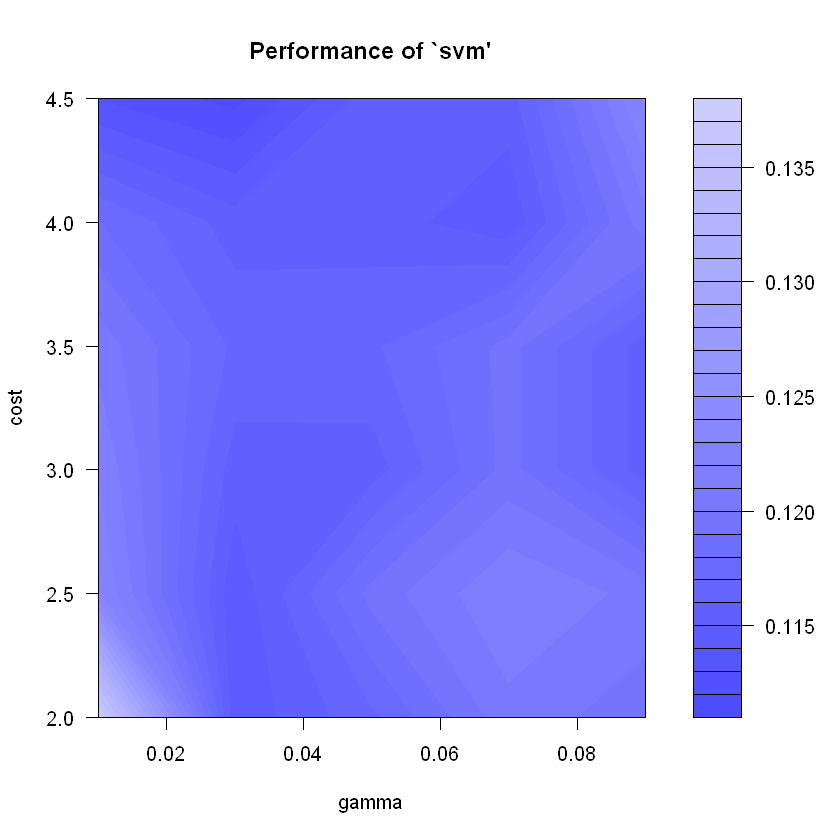

In [141]:
t0 <- Sys.time()

#La zone de recherche est volontairement déjà centré sur les paramètres optimaux
svm.rad.tune = tune.svm(Experience_Level ~ ., data = gym_train_scaled, cost = c(2, 2.5, 3, 3.5,4,4.5), 
    gamma = seq(0.01, 0.1, by = 0.02), kernel= "radial")
plot(svm.rad.tune)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

In [142]:
svm.rad = svm(Experience_Level ~ ., data = gym_train_scaled, 
              cost = svm.rad.tune$best.parameters$cost, 
              gamma = svm.rad.tune$best.parameters$gamma,
              probability=TRUE)

pred.svm.rad=predict(svm.rad,newdata=gym_test_scaled,probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.rad <- attr(pred.svm.rad, "probabilities")
probabilities_svm.rad <- as.data.frame(probabilities_svm.rad)
probabilities_svm.rad <- probabilities_svm.rad[, c("1", "2", "3")]

conf_matrix_svm.rad=table(gym_test_scaled[,"Experience_Level"],pred.svm.rad)
print(conf_matrix_svm.rad)
pourcentage_erreur(conf_matrix_svm.rad)

   pred.svm.rad
     1  2  3
  1 63 12  0
  2 17 64  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.95 %"


Le modèle présente des performances similaires à celles de la régression logistique et de l’analyse discriminante linéaire, avec une erreur de prédiction de 14,95 %. Les erreurs concernent uniquement une confusion entre les niveaux 1 et 2. En revanche, le temps d’exécution est long, autour de 30 secondes.

In [143]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_svm.rad)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "SVM radiale",
  Score = auc_value,
  Temps = as.numeric(execution_time, units = "secs")
))

### SVM kernel polynomial

[1] "Temps d'exécution :  9.83239912986755"


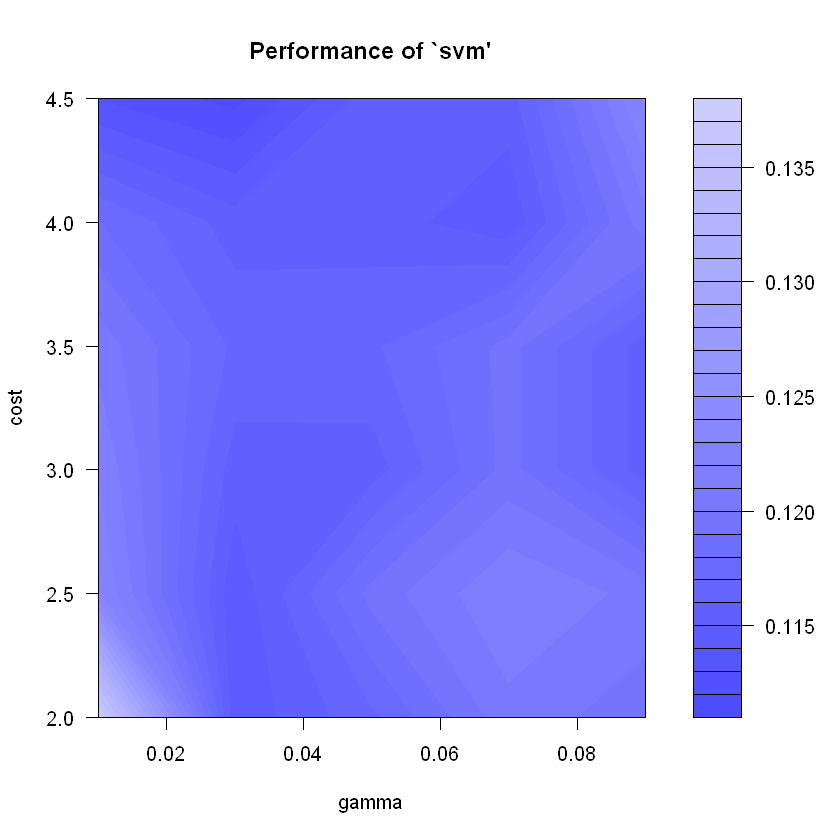

In [144]:
# On peut rajouter :
# coef0 = c(0.5,1,1.5), degree= c(2,3)
# Mais c'est trop long

t0 <- Sys.time()

svm.pol.tune = tune.svm(Experience_Level ~ ., data = gym_train_scaled, kernel= "polynomial", cost = c(3.5,4,4.5,5), 
    gamma = seq(0.01, 0.1, by = 0.02), coef0=1, degree=3) 

plot(svm.rad.tune)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

Le temps d'execution plus raisonnable (11s). En revenche elle de plusieurs minutes quand on ajoute l'optimisation de 'cef0' et 'degree'.

In [145]:
svm.pol = svm(Experience_Level ~ ., data = gym_train_scaled, kernel= "polynomial",
              cost = svm.pol.tune$best.parameters$cost, 
              gamma = svm.pol.tune$best.parameters$gamma,
              coef0 = 1,
              degree = 3,
              probability=TRUE)

pred.svm.pol=predict(svm.pol,newdata=gym_test_scaled,probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.pol <- attr(pred.svm.pol, "probabilities")
probabilities_svm.pol <- as.data.frame(probabilities_svm.pol)
probabilities_svm.pol <- probabilities_svm.pol[, c("1", "2", "3")]

conf_matrix_svm.pol=table(gym_test_scaled[,"Experience_Level"],pred.svm.pol)
print(conf_matrix_svm.pol)
pourcentage_erreur(conf_matrix_svm.pol)

   pred.svm.pol
     1  2  3
  1 64 11  0
  2 17 64  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.43 %"


Pas d'amélioration par rapport au kernel radial sur l'erreur mais une diminution de 20s du temps d'execution. 

In [146]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_svm.pol)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "SVM polynomiale",
  Score = auc_value,
  Temps = as.numeric(execution_time, units = "secs")
))

## Conclusion partie 1 classification 

### Courbes ROC

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



Area under the curve: 0.9594

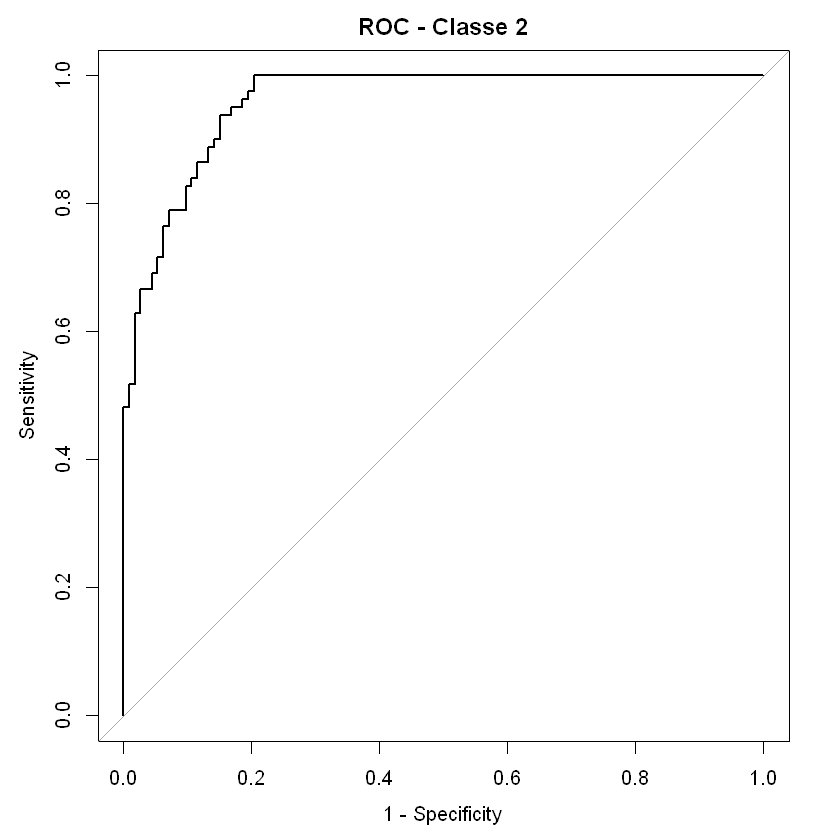

In [149]:
library(pROC)

cl <- "2"
true_class_test <- as.character(true_class_test)
response_test <- true_class_test == cl
predictor_test <- all_probs[[model]][, cl]

roc_test <- roc(response = response_test, predictor = predictor_test)

plot(roc_test, legacy.axes = TRUE, main = paste("ROC - Classe", cl))
auc(roc_test)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Sett

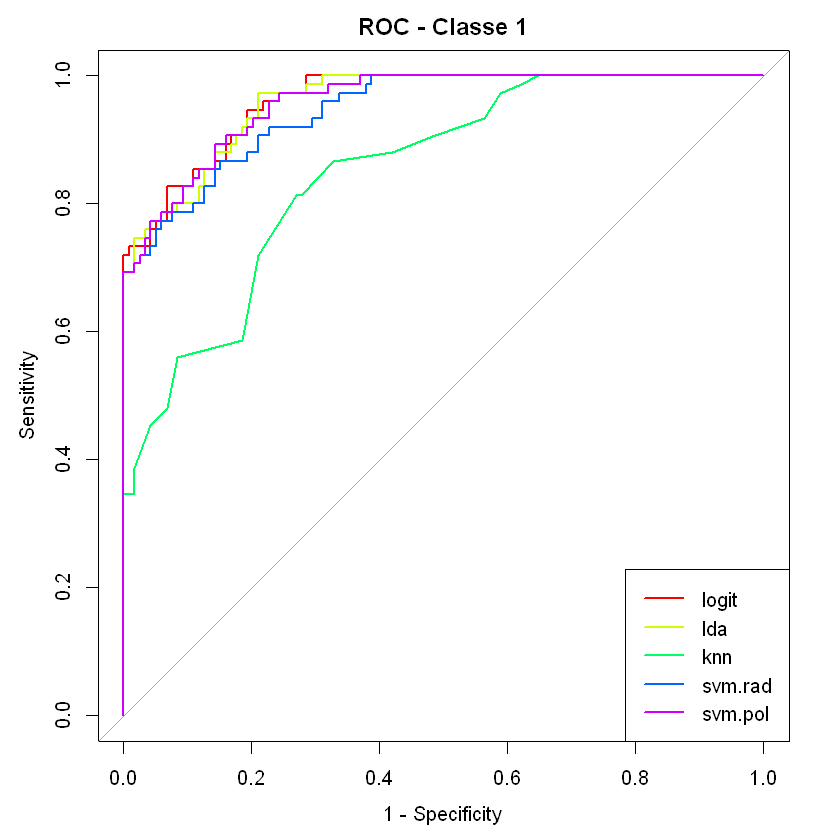

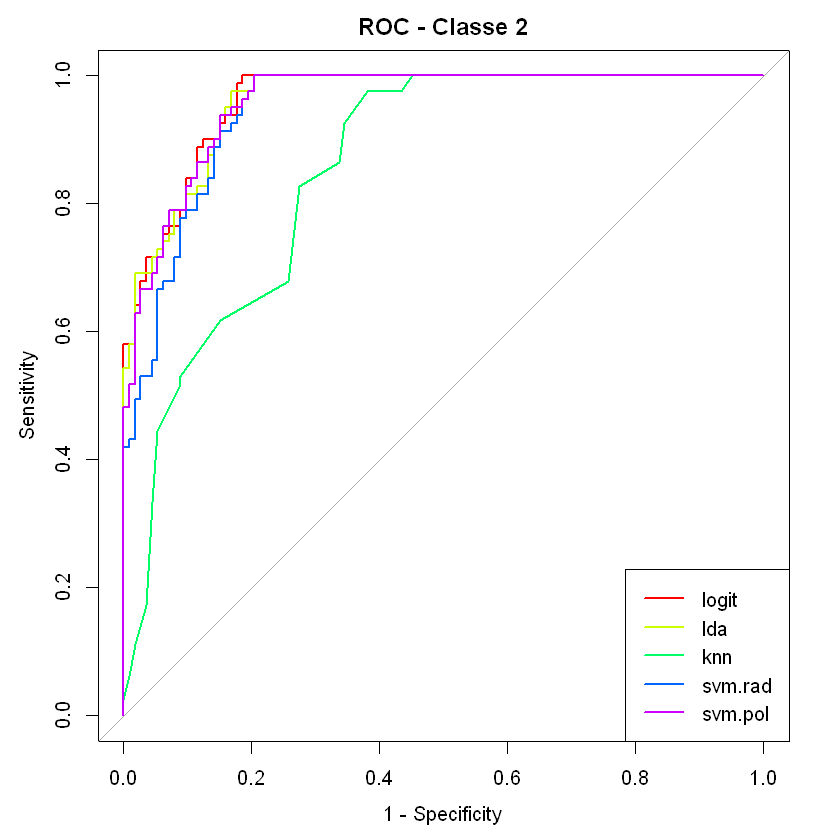

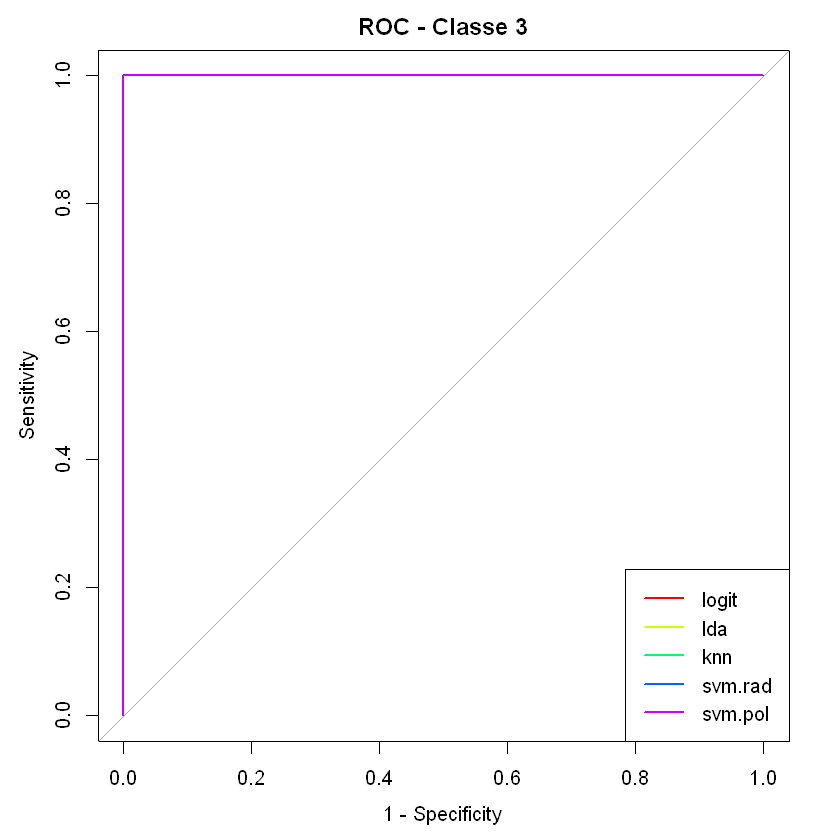

In [153]:
library(pROC)

for (cl in 1:3) {
  # Paramètres
  #cl <- "2"  # classe d’intérêt
  models <- names(all_probs)  # les deux modèles à comparer
  # Génération automatique d'autant de couleurs qu'il y a de modèles
  colors <- rainbow(length(models))
  names(colors) <- models


  # Sécuriser les étiquettes
  true_class_test <- as.character(true_class_test)
  response_test <- true_class_test == cl

  # Préparer la liste pour stocker les objets ROC
  roc_list <- list()

  # Boucle sur les deux modèles
  for (model in models) {
    predictor_test <- all_probs[[model]][, cl]
    roc_obj <- roc(response = response_test, predictor = predictor_test)
    roc_list[[model]] <- roc_obj
  }

  # Tracer la première courbe pour initialiser le plot
  plot(roc_list[[models[1]]],
      col = colors[models[1]],
      lwd = 2,
      legacy.axes = TRUE,
      main = paste("ROC - Classe", cl),
      print.auc = FALSE)

  for (i in 2:length(models)) {
    # Ajouter les courbes ROC pour chaque modèle
    lines(roc_list[[models[i]]], col = colors[models[i]], lwd = 2)
  }

  legend("bottomright", legend = names(all_probs), col = colors, lwd = 2)
}

 

On constate ainsément que pour les niveaux d'expérience 1 et 2, le modèle KNN est le moins performant (courbe verte). Les 4 autres modèles ont des performances assez proches, mais la courbe associée à la regression logit étant souvent legerment au dessus des autres, c'est ce modèle le plus performant. 

### Tableau recapitulatif 

In [152]:
print(results)

          Methode     Score      Temps
1           Logit 0.9812620  1.8574810
2             LDA 0.9802469  0.7685411
3             KNN 0.9272312  1.8674960
4     SVM radiale 0.9737997 29.4472101
5 SVM polynomiale 0.9796433  9.8323991


Le modèle avec le meilleur score, qui est ici un score de généralisation AUC (air sous la courbe ROC), est la regression logistique avec optimisation Lasso. Cette methode à un temps d'execution très court: 2.3 s. Le modèle le moins efficace est KNN, qui n'est pas adapté à notre situation. 